In [72]:
import gudhi
import numpy as np
import pandas as pd
import sys
import pickle

from functions.data_loading import get_filtered_data_range, get_data_range, get_flight_persistence
from functions.data_filtering import complete_flight_filter, filter_by_bools, filter_flights
from functions.data_processing import sublevelset_persistence, clean_flight_data

from traffic.core import Flight
from datetime import datetime
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster

In [73]:
origin = "amsterdam"
destination = "heathrow"

unfiltered_flights, file_name = get_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2023, month=2, day=1))
filtered_flights, file_name = get_filtered_data_range(unfiltered_flights, file_name, complete_flight_filter(origin, destination, 0.75)) 
del unfiltered_flights
#persistences, file_name = get_flight_persistence(filtered_flights, file_name)

In [74]:
from tqdm import tqdm
trees = []

trees, paths = sublevelset_persistence(filtered_flights)

100%|██████████| 470/470 [00:45<00:00, 10.37it/s]


In [75]:
condensed_distance_matrix = []
for i in tqdm(range(len(trees))):
    for j in range(i+1, len(trees)):
        pers_i = trees[i].persistence_intervals_in_dimension(0)
        pers_j = trees[j].persistence_intervals_in_dimension(0)
        dist = gudhi.bottleneck_distance(np.array(pers_i), np.array(pers_j), 0.0001)
        condensed_distance_matrix.append(dist)

100%|██████████| 470/470 [00:12<00:00, 37.88it/s] 


In [76]:
with open("data/condensed_distance_matrix.pkl", "wb") as f:
    pickle.dump(condensed_distance_matrix, f)

In [77]:
with open("data/condensed_distance_matrix.pkl", "rb") as f:
    condensed_distance_matrix = pickle.load(f)

In [78]:
sys.setrecursionlimit(10000)

Z = linkage(condensed_distance_matrix, "complete")

#fig = plt.figure(figsize=(100, 10))
#dn = dendrogram(Z)

#clustering = fcluster(Z, t=2, criterion='inconsistent', depth=3)
clustering = fcluster(Z, t=4, criterion='maxclust', depth=2)


In [79]:
for i in range(1, len(np.unique(clustering))+1):
    print(f"{i}: {sum(clustering == i)}")

1: 32
2: 16
3: 2
4: 420


In [80]:
from traffic.core import Traffic

bool_array = clustering == 1

loopy_flight_cluster = filter_flights(filter_by_bools(bool_array), filtered_flights)
loopy_flight_cluster_pers = list(filter(filter_by_bools(bool_array), trees))
print(len(loopy_flight_cluster))

32


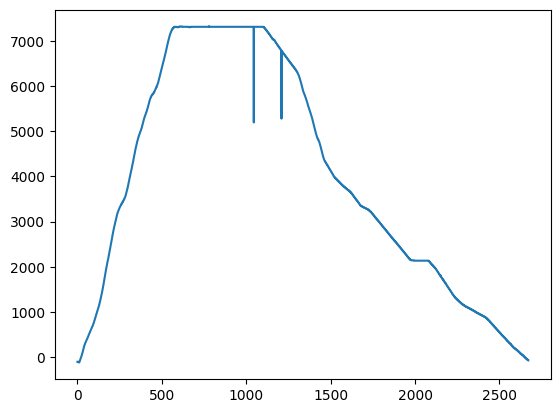

In [81]:
i = 15
data = paths[i]
x_values = [x for x in range(len(data))]

plt.plot(x_values, data)

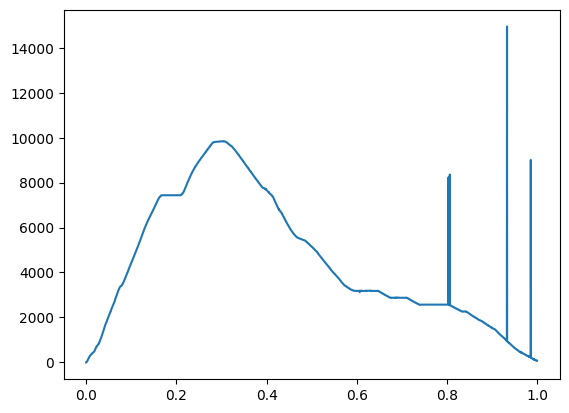

In [82]:
data = loopy_flight_cluster[i].data["geoaltitude"]
x_values = [x / len(data) for x in range(len(data))]
plt.plot(x_values, data, 100)

In [88]:
from gudhi.representations import Landscape

resolution = 15
n_landscapes = 4
landscape = Landscape(resolution=resolution, num_landscapes=n_landscapes)

pers = trees[0].persistence_intervals_in_dimension(0)
pers

array([[2743.19995117, 2750.82006836],
       [3048.        , 3055.62011719],
       [3048.        , 3055.62011719],
       [3048.        , 3055.62011719],
       [7909.56005859, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 7924.79980469],
       [7917.18017578, 79

In [85]:

landscape.fit_transform([pers])

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan]])

C:\Users\tobso\Desktop\programering\masters-thesis\venv\Lib\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

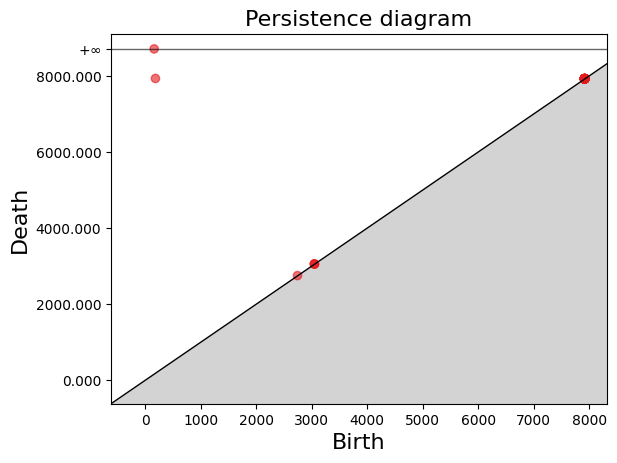

In [87]:
gudhi.persistence_graphical_tools.plot_persistence_diagram(pers)

0 clue whatsoever why it fails to make a persistance diagram. are the values too large?